## Extracting and Preparing the Dataset

In [3]:
import os
import zipfile

# Load compressed dataset (data.zip) and extract it into /tmp
local_zip = "data.zip" # make sure to have the correct path

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


## Importing Required Libraries

In [4]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Dataset Cleaning and Exploration

In [6]:
# Get train and test data
train_path = "/tmp/data/training_set/training_set"
test_path = "/tmp/data/test_set/test_set"

cats_train = os.listdir(train_path + "/cats")
dogs_train = os.listdir(train_path + "/dogs")
cats_test = os.listdir(test_path + "/cats")
dogs_test=os.listdir(test_path + "/dogs")

print(len(cats_test))
print(len(cats_train))
print(len(dogs_test))
print(len(dogs_train))

1012
4001
1013
4006


In [7]:
# Remove _DS_Store_ files
for i in cats_train:
  if i == "_DS_Store":
    cats_train.pop(cats_train.index(i))

for i in cats_test:
  if i == "_DS_Store":
    cats_test.pop(cats_test.index(i))

for i in dogs_train:
  if i == "_DS_Store":
    dogs_train.pop(dogs_train.index(i))

for i in dogs_test:
  if i == "_DS_Store":
    dogs_test.pop(dogs_test.index(i))


In [8]:
print(len(cats_test))
print(len(cats_train))
print(len(dogs_test))
print(len(dogs_train))

1011
4000
1012
4005


In [9]:
# Create train and test datasets, and label them with 1 for cat and 0 for dog

train_labels = []
train_path_ = []

for i in cats_train:
  train_labels.append(1)
  train_path_.append(train_path + "/cats/")

for i in dogs_train:
  train_labels.append(0)
  train_path_.append(train_path + "/dogs/")


test_labels = []
test_path_ = []

for i in cats_test:
  test_labels.append(1)
  test_path_.append(test_path + "/cats/")

for i in dogs_test:
  test_labels.append(0)
  test_path_.append(test_path + "/dogs/")

train_imgs = cats_train + dogs_train

test_imgs = cats_test + dogs_test

train_dic = {'path': train_path_, 'images': train_imgs, 'labels': train_labels}
test_dic = {'path': test_path_, 'images': test_imgs, 'labels': test_labels}

train = pd.DataFrame(train_dic)
test = pd.DataFrame(test_dic)

In [10]:
train.head()

,path,images,labels
0,/tmp/data/training_set/training_set/cats/,cat.3161.jpg,1
1,/tmp/data/training_set/training_set/cats/,cat.600.jpg,1
2,/tmp/data/training_set/training_set/cats/,cat.1923.jpg,1
3,/tmp/data/training_set/training_set/cats/,cat.3333.jpg,1
4,/tmp/data/training_set/training_set/cats/,cat.896.jpg,1


In [11]:
test.head()

,path,images,labels
0,/tmp/data/test_set/test_set/cats/,cat.4359.jpg,1
1,/tmp/data/test_set/test_set/cats/,cat.4864.jpg,1
2,/tmp/data/test_set/test_set/cats/,cat.4133.jpg,1
3,/tmp/data/test_set/test_set/cats/,cat.4923.jpg,1
4,/tmp/data/test_set/test_set/cats/,cat.4979.jpg,1


In [12]:
# Shuffle datasets to avoid training bias
train = shuffle(train, random_state=42).reset_index(drop=True)
train.head()

,path,images,labels
0,/tmp/data/training_set/training_set/dogs/,dog.1923.jpg,0
1,/tmp/data/training_set/training_set/dogs/,dog.2706.jpg,0
2,/tmp/data/training_set/training_set/dogs/,dog.1251.jpg,0
3,/tmp/data/training_set/training_set/cats/,cat.133.jpg,1
4,/tmp/data/training_set/training_set/dogs/,dog.2398.jpg,0


In [13]:
test = shuffle(test, random_state=42).reset_index(drop=True)
test.head()

,path,images,labels
0,/tmp/data/test_set/test_set/cats/,cat.4060.jpg,1
1,/tmp/data/test_set/test_set/cats/,cat.4265.jpg,1
2,/tmp/data/test_set/test_set/cats/,cat.4315.jpg,1
3,/tmp/data/test_set/test_set/cats/,cat.4787.jpg,1
4,/tmp/data/test_set/test_set/cats/,cat.4247.jpg,1


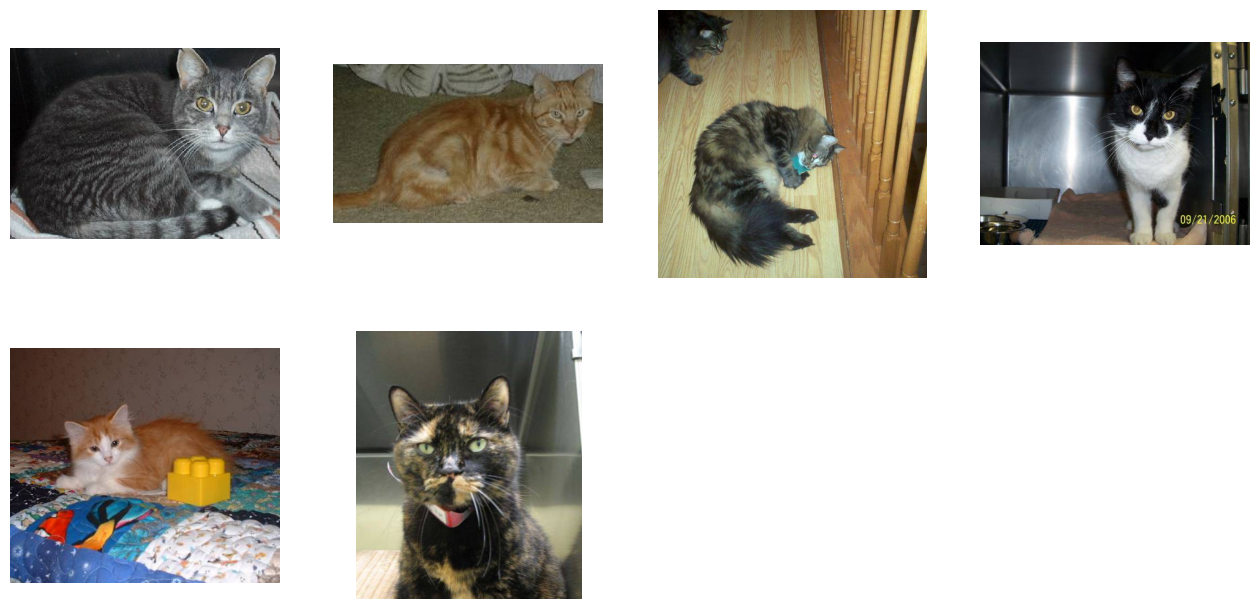

In [14]:
# Visualize Sample Images
def show_image(path, image_list, number_of_images):
    nrows=4
    ncols=4
    fig = plt.gcf()
    fig.set_size_inches(ncols*4, nrows*4)


    for i in range(number_of_images):
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        img = mpimg.imread(path + "/" + image_list[i])
        plt.imshow(img)

show_image(train_path + "/cats", cats_train, 6)

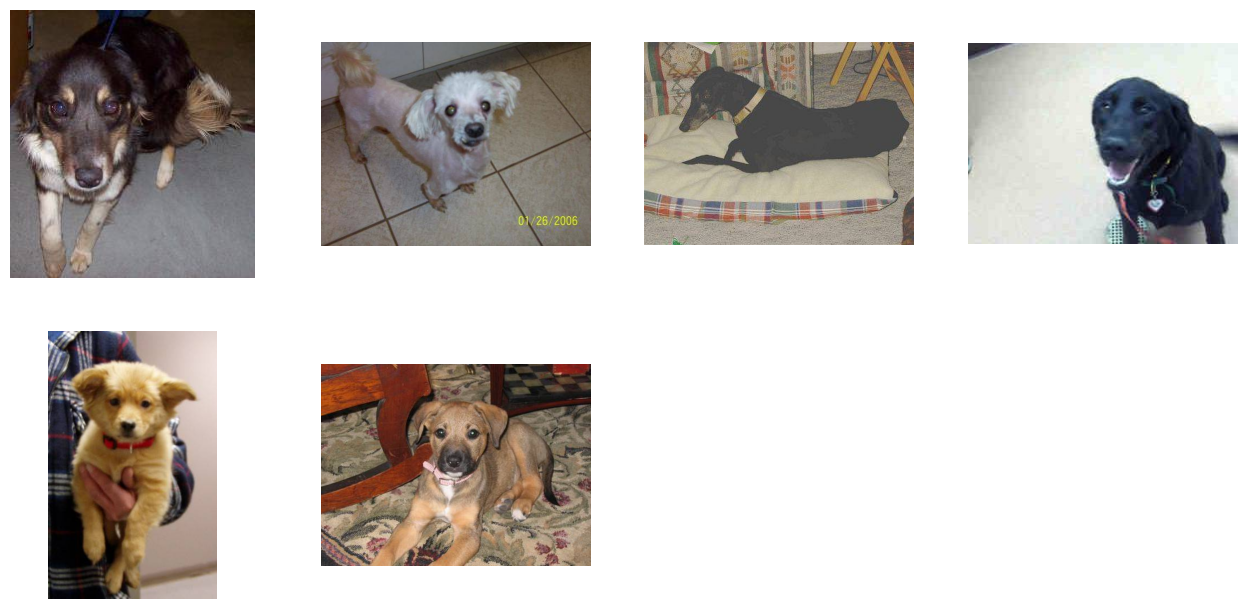

In [15]:
show_image(train_path + "/dogs", dogs_train, 6)

### Image Preprocessing

In [16]:
training_images = []
testing_images = []

# Load images using load_img and resize them to 150×150
for i in range(len(train)):
    training_images.append(load_img(os.path.join(train.path[i], train.images[i]), target_size=(150, 150)))

for i in range(len(test)):
    testing_images.append(load_img(os.path.join(test.path[i], test.images[i]), target_size=(150, 150)))


In [17]:
# Convert into arrays with img_to_array and normalize pixel values by dividing by 255
training_images = np.array([img_to_array(img) for img in training_images])/255
testing_images = np.array([img_to_array(img) for img in testing_images])/255

In [18]:
train_targets = np.array(train.labels.tolist())
test_targets = np.array(test.labels.tolist())

In [19]:
# Data Augmentation
aug=ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

## Model Creation and Training

In [20]:
# CNN model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Model Compilation
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    75,760,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,132,481 (290.42 MB)

 Trainable params: 76,132,481 (290.42 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Model training

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history=model.fit(aug.flow(training_images, train_targets, batch_size=128),
                  steps_per_epoch=len(training_images)//128,
                  epochs=200,
                  validation_data=(testing_images, test_targets),
                  callbacks=[early_stopping],
                  verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 74s 926ms/step - accuracy: 0.5027 - loss: 1.4515 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 2/200
 1/62 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.5234 - loss: 0.6883

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5234 - loss: 0.6883 - val_accuracy: 0.5002 - val_loss: 0.6913
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 753ms/step - accuracy: 0.5296 - loss: 0.6904 - val_accuracy: 0.5828 - val_loss: 0.6795
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6016 - loss: 0.6763 - val_accuracy: 0.5877 - val_loss: 0.6789
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 46s 739ms/step - accuracy: 0.5857 - loss: 0.6726 - val_accuracy: 0.6194 - val_loss: 0.6510
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5234 - loss: 0.6888 - val_accuracy: 0.6144 - val_loss: 0.6528
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 45s 728ms/step - accuracy: 0.6091 - loss: 0.6577 - val_accuracy: 0.5803 - val_loss: 0.6847
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5703 - loss: 0.6870 - val_accuracy: 0.5344 - val_loss: 0.6854
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 741ms/step - accuracy: 0.5468 - loss: 0.6799 - val_accuracy: 0.6243

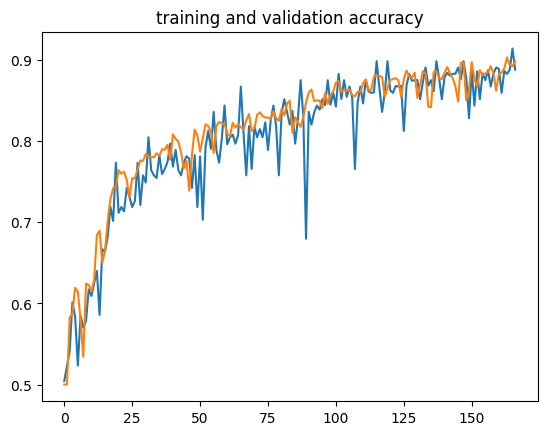

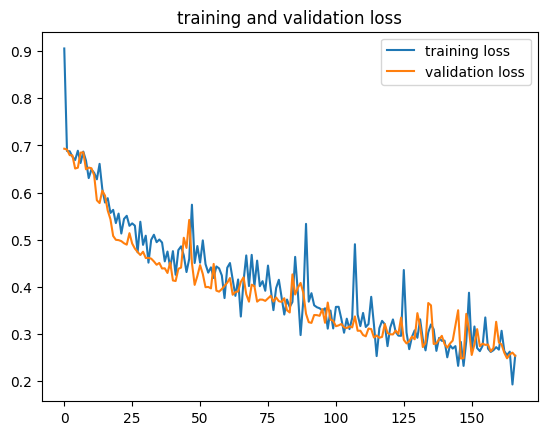

In [22]:
# Training visualization - plot accuracy and loss

acc=history.history["accuracy"]
loss=history.history["loss"]

val_acc=history.history["val_accuracy"]
val_loss=history.history["val_loss"]

epochs = range(len(acc))

plt.figure()

plt.plot(epochs, acc, label="training accuracy")
plt.plot(epochs, val_acc, label="validation accuracy")
plt.title("training and validation accuracy")

plt.figure()

plt.plot(epochs, loss, label="training loss")
plt.plot(epochs, val_loss, label="validation loss")
plt.title("training and validation loss")

plt.legend()
plt.show()


In [23]:
# Model saving and reloading
model.save('cats-vs-dogs-model.h5')
model = tf.keras.models.load_model('cats-vs-dogs-model.h5')

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    75,760,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,132,483 (290.42 MB)

 Trainable params: 76,132,481 (290.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Model Evaluation

In [25]:
predictions = (model.predict(testing_images) > 0.5).astype("int32")

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


In [26]:
count = 0

for i in range(len(test_targets)):
  if test_targets[i] == predictions[i][0]:
    count = count + 1

acc = (count/len(test_targets)) * 100
acc

89.66880869995056

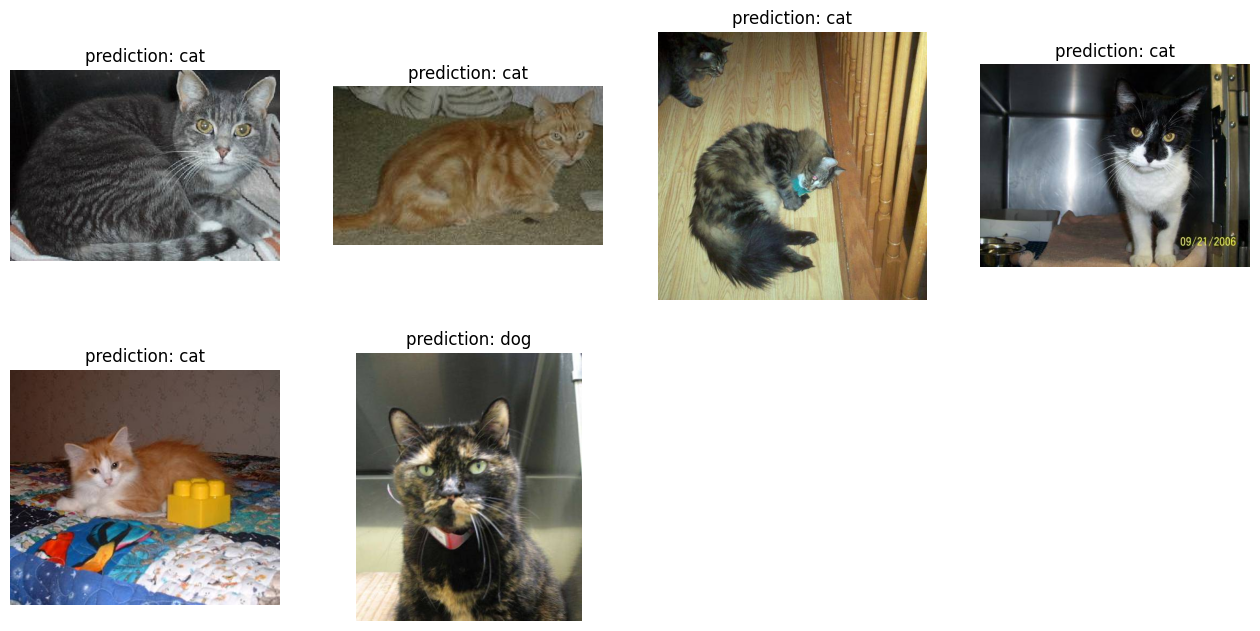

In [27]:
# Prediction visualization
def show_image(path, image_list, number_of_images):
    nrows=4
    ncols=4
    fig = plt.gcf()
    fig.set_size_inches(ncols*4, nrows*4)


    for i in range(number_of_images):
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        if predictions[i][0] == 1:
          plt.title("prediction: cat")
        else:
          plt.title("prediction: dog")
        img = mpimg.imread(path + "/" + image_list[i])
        plt.imshow(img)

show_image(train_path + "/cats", cats_train, 6)